# Icon Understanding with Llava-Next and Structured Generation

NOTE: useless

In [45]:
import os
import json
import base64
import requests
from io import BytesIO

import cv2
import numpy as np
import pandas as pd
import huggingface_hub
from PIL import Image, ImageOps, ImageDraw
from PIL.Image import Image as PILImage
from transformers import LlavaNextProcessor
from transformers.image_processing_utils import select_best_resolution

In [24]:
PROMPT_FORMAT = "<system_prompt> USER: <image>\\n<user> ASSISTANT: "
SYSTEM_PROMPT_FORMAT = """You are an icon fill-in-the-blank bot. You will receive an image as an input and you must answer the user's question based on the image. Be concise and limit responses to at most 3 sentences, preferably one sentence long. Respond in English. Output in the following json format: <json_format>."""

In [25]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-13b-hf")

In [26]:
possible_resolutions = processor.image_processor.image_grid_pinpoints
# possible_resolutions += [
#     [672, 1008],
#     [1008, 672],
#     [1008, 1008],
# ]

In [27]:
def resize_and_pad_image(image: PILImage) -> PILImage:
    best_resolution = select_best_resolution(image.size, possible_resolutions)
    print(f"{best_resolution = }")
    resized_image = ImageOps.cover(image, best_resolution)
    resized_and_padded_image = ImageOps.pad(
        resized_image,
        best_resolution,
        method=processor.image_processor.resample,
        color=(255,255,255,0),
    )
    return resized_and_padded_image


def encode_local_image(image_path, resize_and_pad: bool=True):
    # load image
    image = Image.open(image_path)
    if ".gif" in image_path:
        image = image.convert("RGB")
    if resize_and_pad:
        image = resize_and_pad_image(image)
        print(f"New size: {image.size}")

    # Convert the image to a base64 string
    buffer = BytesIO()
    image.save(buffer, format="PNG")  # Use the appropriate format (e.g., JPEG, PNG)
    base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # add string formatting required by the endpoint
    image_string = f"data:image/png;base64,{base64_image}"

    return image_string

In [28]:
def format_title(image_path: str) -> str:
    title = image_path.split("/")[-1].split(".")[0]
    return title.replace("-", " ").replace("_", " ")

In [72]:
def count_objects(image_path: str) -> int:
    image = Image.open(image_path)
    ImageDraw.floodfill(image, xy=(0,0), value=(255,255,255), thresh=50)
    image = image.convert("RGB")
    image_np = np.array(image)

    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    ret, _ = cv2.threshold(gray,127,255,1)
    contours, _ = cv2.findContours(ret, 1, 2)
    count = len(contours)
    return count

In [73]:
def build_tool(question: str):
    is_asking_time = ("what time" in question.lower())
    return {
        "type": "function",
        "function": {
            "name": "infographic_explainer_tool",
            "description": "Infographic Explair Tool",
            "parameters": {
                "type": "object",
                "properties": {
                    "1_reasoning": {"type": "string"},
                    "2_answer": {
                        "type": "string" if is_asking_time else "integer",
                        "description": "Concise answer to the user question."
                    },
                },
                "required": ["1_reasoning", "2_answer"],
            },
        }
    }

In [74]:
API_URL = "https://bkliyhzstf7g5dyz.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

In [75]:
def run_inference(image_path, question, seed=0, max_length: int=100):
    image_base64 = encode_local_image(image_path)
    question_trimmed = question[len("<image>\n"):].split("\"")[1]
    # title = format_title(image_path)
    # print(f"{title = } | {question_trimmed = }")
    num_objects = count_objects(image_path)
    print(f"{question_trimmed = } | {num_objects = }")
    tool = build_tool(question_trimmed)

    system_prompt = SYSTEM_PROMPT_FORMAT.replace(
        "<json_format>",
        json.dumps(tool["function"]["parameters"]["properties"]),
    )
    prompt = (
        PROMPT_FORMAT
        .replace("<system_prompt>", system_prompt)
        .replace("<image>", f"![]({image_base64})")
        .replace("<user>", f"There are {num_objects} objects in the image. {question_trimmed}" + (" Fill in the blank (_): " if "(_)" in question else ""))
    )
    print(f"{prompt = }")

    # This version of TGI uses an older version of Outlines
    # which re-orders the keys in the JSON in alphabetical order.
    # Hence the prefixes in the keys in the grammer
    response = query({
        "inputs": prompt,
        "parameters": {
            "return_full_text": False,
            "max_new_tokens": 2048,
            "frequency_penalty": 1,
            "temperature": 1,
            "top_p": 0.95,
            "frequency_penalty": 0,
            "presence_penalty": 0,
            "grammar": {
                "type": "json",
                "value": tool["function"]["parameters"],
            }
        }
    })
    print(f"{response = }")

    return json.loads(response[0]["generated_text"])["2_answer"]

best_resolution = (672, 336)


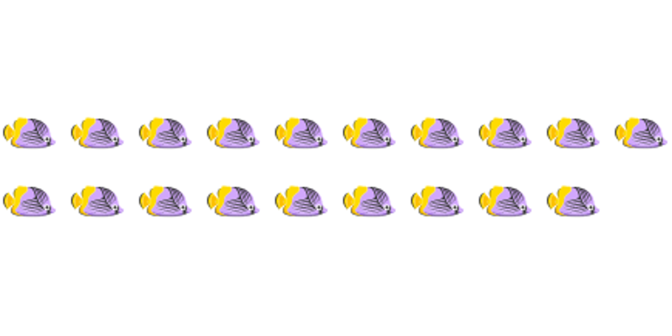

In [76]:
image_path = "data/raw_datasets/iconqa/iconqa_data/iconqa/val/fill_in_blank/20847/image.png"
image = Image.open(image_path)
image = resize_and_pad_image(image)
image

In [ ]:
print(f"{count_objects(image_path) = }")

In [ ]:
question = """<image>\nRepresent the icon. Question "How many fish are there?" Fill in the empty spaces:"""
answer = run_inference(image_path, question, seed=460)
answer

In [16]:
dataset_name = "iconqa_fill_in_blank"
dataset_path = os.path.join("data/processed_data", dataset_name, "converted_output_test.json")
print(dataset_path)
assert os.path.exists(dataset_path)

df_data = pd.read_json(dataset_path)

data/processed_data/iconqa_fill_in_blank/converted_output_test.json


In [18]:
!mkdir -p inference_results/llava-1-6-vicuna-13b-hf

In [ ]:
failed_idx = set()
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"

    image_path = row['image']
    question = row["conversations"][0]["value"]

    if os.path.exists(answer_txt_path):
        continue
    print(id, idx, question)
    print(image_path)

    try:
        answer = run_inference(image_path, question, seed=7812)
        print(f"{answer = }")
        with open(answer_txt_path, "w") as f:
            f.write(str(answer))
    except Exception as e:
        print(">>>>>>> ERROR", idx, row, e, "<<<<<<<")
        failed_idx.add(idx)
    print("---------")

In [ ]:
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"
    if not os.path.exists(answer_txt_path):
        failed_idx.add(idx)
        continue

    with open(answer_txt_path, "r") as f:
        answer = f.read()

    if len(answer) >= 50:
        failed_idx.add(idx)

In [ ]:
failed_idx

In [ ]:
df_data.iloc[list(failed_idx)]

In [ ]:
failed_idx_2 = set()
for idx, row in df_data.iloc[list(failed_idx)].iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"
    if os.path.exists(answer_txt_path):
        os.remove(answer_txt_path)
    print(id, idx)

    image_path = f"data/raw_datasets/{dataset_name}/images/{row['image']}"
    question = row["conversations"][0]["value"]

    try:
        answer = run_inference(image_path, question, seed=42)
        with open(answer_txt_path, "w") as f:
            f.write(answer)
    except Exception as e:
        print(idx, row, e)
        failed_idx_2.add(idx)

In [ ]:
failed_idx_2

{220}

In [ ]:
df_data.iloc[220]["image"]

In [ ]:
df_data.iloc[220]["conversations"]